# A Basic Keras Model for Drainage Pipe Condition Classification

This project has very much drawn inspiration from the infamous flower classification project, see here: https://www.tensorflow.org/tutorials/images/classification. The model utilises a Keras Sequential to classify images of drainage pipes, aiding in assessing their condition. The model comprises three convolutional blocks (tf.keras.layers.Conv2D) each followed by a max pooling layer (tf.keras.layers.MaxPooling2D). On top of these, a fully connected layer (tf.keras.layers.Dense) with 128 units activated by a ReLU function is employed. While this model is basic and not optimized for high accuracy, it serves as a foundation to demonstrate a typical approach in image classification tailored to our specific use case – evaluating the state of drainage pipes, or, at least class them as damaged, being in good condition, having roots, etc.

## Setup

Import TensorFlow and other necessary libraries:

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load the training dataset

In [77]:
import pathlib

data_dir = pathlib.Path('images-initial-training-batch').with_suffix('')

In [78]:
print(data_dir)

images-initial-training-batch


After downloading, you should now have a copy of the dataset available. There are 1669 total images:

In [79]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1669


Here is an example of a pipe in good condition:

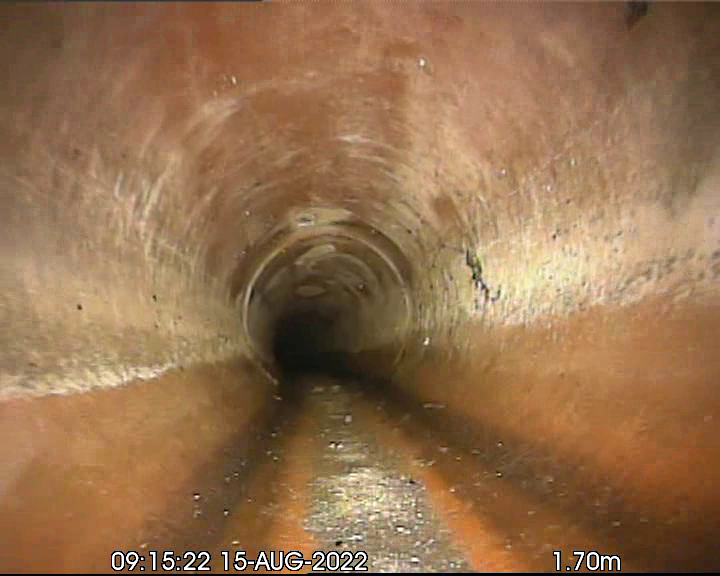

In [80]:
ok_condition = list(data_dir.glob('ok_condition/*'))
PIL.Image.open(str(ok_condition[0]))

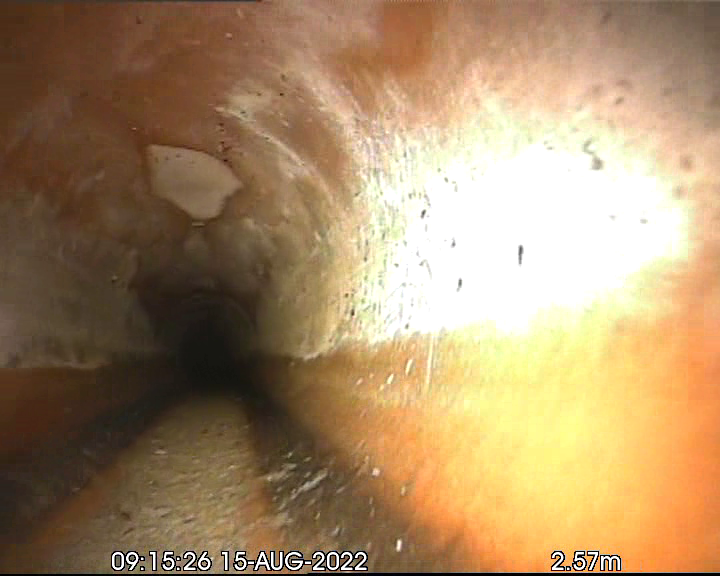

In [81]:
PIL.Image.open(str(ok_condition[1]))

Roots in the pipe:

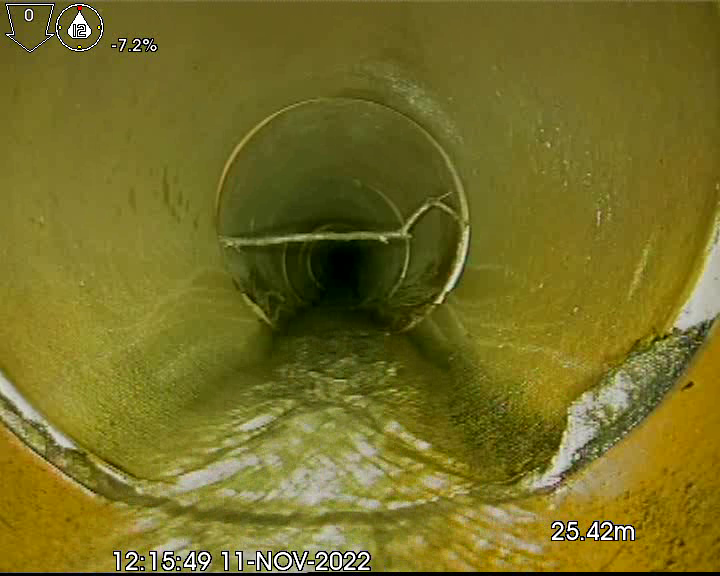

In [82]:
roots = list(data_dir.glob('roots/*'))
PIL.Image.open(str(roots[0]))

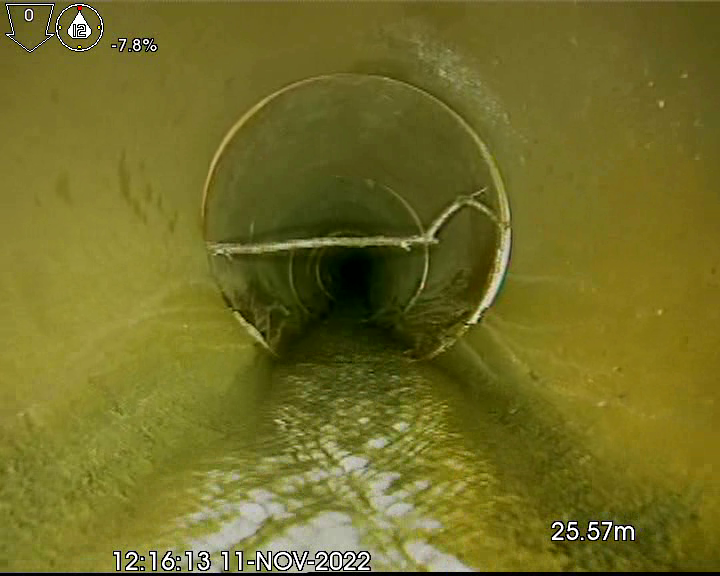

In [83]:
PIL.Image.open(str(roots[1]))

## Load data using a Keras utility

We utilise tf.keras.utils.image_dataset_from_directory to efficiently load the dataset from the directory, preparing it for the training process. This utility simplifies the process of loading images, converting them into a suitable format for our model.

### Create a dataset

Define some parameters for the loader:

In [84]:
batch_size = 32
img_height = 300
img_width = 300

We split the data into training and validation sets to ensure our model is generalizable and can perform well on unseen data. Typically, we use 80% of the data for training and reserve 20% for validation.

In [85]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1669 files belonging to 6 classes.
Using 1336 files for training.


In [86]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1669 files belonging to 6 classes.
Using 333 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [87]:
class_names = train_ds.class_names
print(class_names)

['damage_fracture_collapse', 'deposit_rubble_rubbish', 'joint_displacement', 'ok_condition', 'roots', 'water_present']


## Visualize the data

Here are the first nine images from the training dataset:

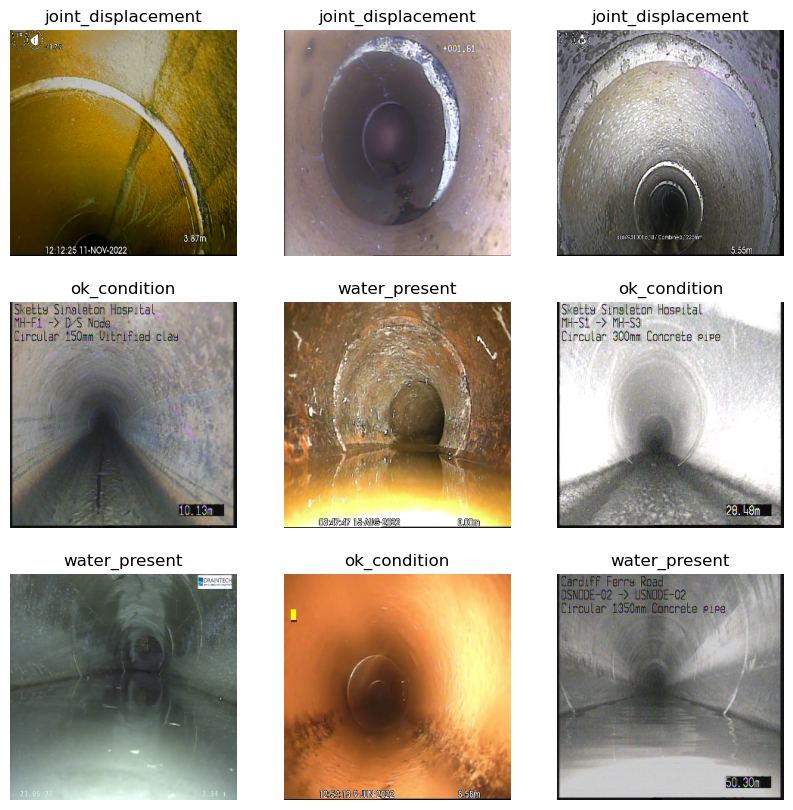

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [89]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 300, 300, 3)`. This is a batch of 32 images of shape `300x300x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


## Configure the dataset for performance



In [90]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardise the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.


## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [91]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [93]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 64)       

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [94]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


42/42 [==============================] - 77s 2s/step - loss: 1.8341 - accuracy: 0.3466 - val_loss: 1.2783 - val_accuracy: 0.4955
Epoch 2/15
42/42 [==============================] - 99s 2s/step - loss: 1.2135 - accuracy: 0.5269 - val_loss: 1.0168 - val_accuracy: 0.6006
Epoch 3/15
42/42 [==============================] - 103s 2s/step - loss: 1.0123 - accuracy: 0.6250 - val_loss: 0.9940 - val_accuracy: 0.6306
Epoch 4/15
42/42 [==============================] - 90s 2s/step - loss: 0.7484 - accuracy: 0.7111 - val_loss: 0.8914 - val_accuracy: 0.6727
Epoch 5/15
42/42 [==============================] - 106s 3s/step - loss: 0.5532 - accuracy: 0.7889 - val_loss: 0.8907 - val_accuracy: 0.6577
Epoch 6/15
42/42 [==============================] - 85s 2s/step - loss: 0.3411 - accuracy: 0.8885 - val_loss: 1.0348 - val_accuracy: 0.6697
Epoch 7/15
42/42 [==============================] - 70s 2s/step - loss: 0.1978 - accuracy: 0.9394 - val_loss: 1.1658 - val_accuracy: 0.6637
Epoch 8/15
42/42 [===========

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

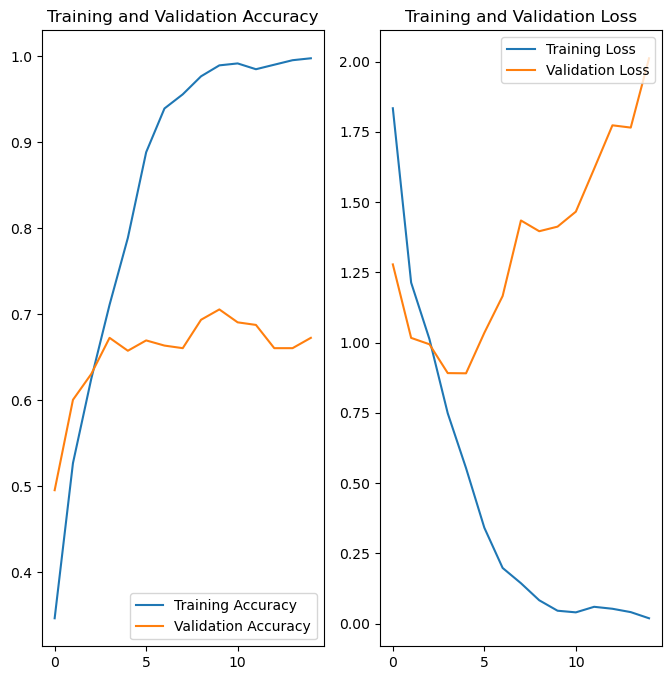

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Stalling validation accuracy at 70% indicates overfitting. SO we will need to augment and dropout.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [38]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

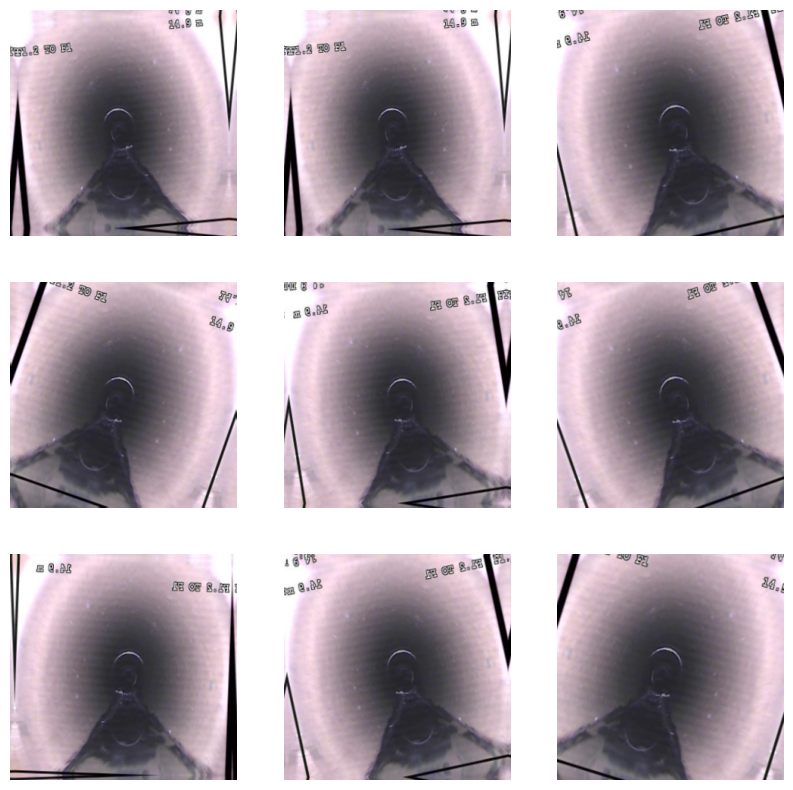

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [40]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

In [43]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


42/42 [==============================] - 43s 984ms/step - loss: 1.7820 - accuracy: 0.3361 - val_loss: 1.4493 - val_accuracy: 0.4384
Epoch 2/15
42/42 [==============================] - 44s 1s/step - loss: 1.4621 - accuracy: 0.3690 - val_loss: 1.3065 - val_accuracy: 0.4535
Epoch 3/15
42/42 [==============================] - 44s 1s/step - loss: 1.3579 - accuracy: 0.4439 - val_loss: 1.2173 - val_accuracy: 0.5015
Epoch 4/15
42/42 [==============================] - 43s 1s/step - loss: 1.2496 - accuracy: 0.5187 - val_loss: 1.1310 - val_accuracy: 0.5435
Epoch 5/15
42/42 [==============================] - 46s 1s/step - loss: 1.1719 - accuracy: 0.5217 - val_loss: 1.1459 - val_accuracy: 0.5646
Epoch 6/15
42/42 [==============================] - 49s 1s/step - loss: 1.1358 - accuracy: 0.5531 - val_loss: 1.0937 - val_accuracy: 0.5646
Epoch 7/15
42/42 [==============================] - 46s 1s/step - loss: 1.1051 - accuracy: 0.5734 - val_loss: 1.1143 - val_accuracy: 0.5736
Epoch 8/15
42/42 [==========

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

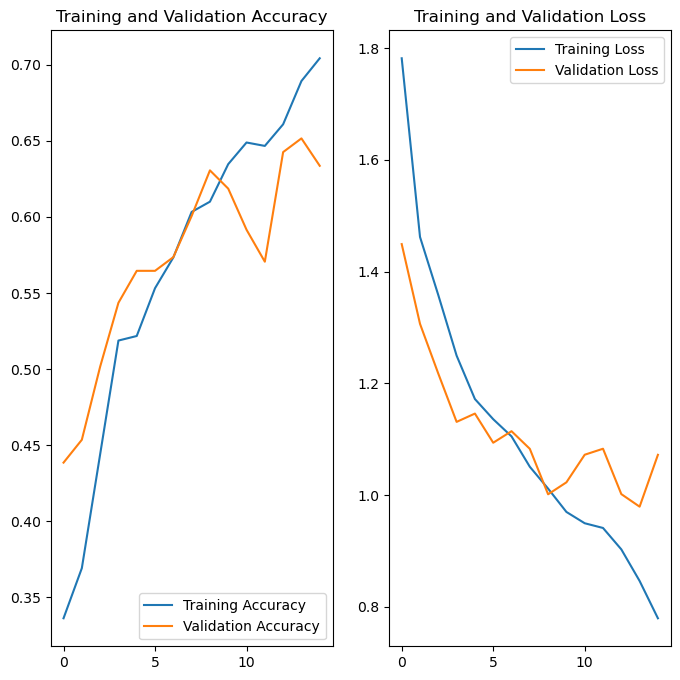

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Let's use your model to classify an image that wasn't included in the training or validation sets.

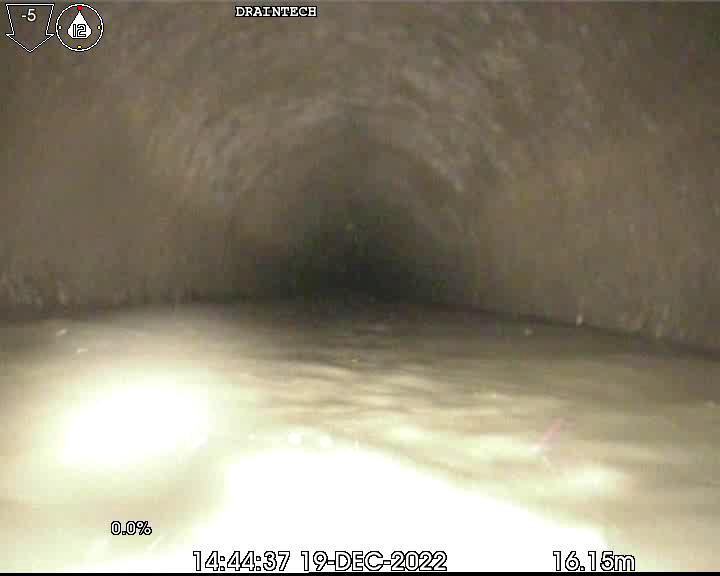

In [58]:
pipe_with_tons_of_water_test_path = "quick-prediction-test/pipe-with-tons-of-water.jpg"
PIL.Image.open(pipe_with_tons_of_water_test_path)

In [57]:

img = tf.keras.utils.load_img(
    pipe_with_tons_of_water_test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 36ms/step
This image most likely belongs to water_present with a 78.64 percent confidence.


thst's a bloody good guess

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [69]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('initial-model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmpe98bzgzn\assets


INFO:tensorflow:Assets written to: C:\Users\patry\AppData\Local\Temp\tmpe98bzgzn\assets


The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [70]:
TF_MODEL_FILE_PATH = 'initial-model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [71]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [72]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [73]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [74]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to water_present with a 78.64 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [75]:
print(np.max(np.abs(predictions - predictions_lite)))

9.536743e-06


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).